# **08 Predictive model**

## Objectives

* Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* housing_cleaned.csv

## Outputs

* test_set.csv


---

# Baseline model

Import packages

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 


In [107]:
# read in the cleaned data
df = pd.read_csv('../data/clean/housing_cleaned.csv')

---

In [108]:
# convert to datetime
df['transfer_date'] = pd.to_datetime(df['transfer_date'])
# keep only the transfer_date for 2024 onwards
df = df[df['transfer_date'].dt.year >= 2024]

In [109]:
# set model features
num_feats   = ['log_total_floor_area','IMD_Rank','energy_band_num']
bin_feats   = ['new_build','is_leasehold']  # pass through as 0/1
cat_feats   = ['property_type','county']

# Control category order to set baselines via drop='first'
ptype_order = ['D','S','T','F']  # baseline becomes 'D' (Detached)
county_order = [
    'WEST MIDLANDS','WARWICKSHIRE','WORCESTERSHIRE','LEICESTERSHIRE',
    'LEICESTER','STAFFORDSHIRE','DERBYSHIRE','CITY OF DERBY','STOKE-ON-TRENT'
]  # baseline becomes WEST MIDLANDS

# Build the ColumnTransformer (code suggested by Copilot)
pre = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first',
                              categories=[ptype_order, county_order],
                              handle_unknown='ignore'),
         cat_feats),
        ('bin', 'passthrough', bin_feats),
    ],
    remainder='drop'
)

# End-to-end pipeline
pipeline = Pipeline([
    ('pre', pre),
    ('model', LinearRegression()) # or Ridge(alpha=1.0)
])

X = df[num_feats + cat_feats + bin_feats]
y = df['log_price']  # log1p(price)

# Train / Test split on random 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['log_total_floor_area',
                                                   'IMD_Rank',
                                                   'energy_band_num']),
                                                 ('cat',
                                                  OneHotEncoder(categories=[['D',
                                                                             'S',
                                                                             'T',
                                                                             'F'],
                                                                            ['WEST '
                                                                             'MIDLANDS',
                                                                             'WARWICKSHIRE',
                                                                             'WORCESTERSHIRE',
                                                                             'LEICESTERSHIRE',
                                                                             'LEICESTER',
                                                                             'STAFFORDSHIRE',
                                                                             'DERBYSHIRE',
                                                                             'CITY '
                                                                             'OF '
                                                                             'DERBY',
                                                                             'STOKE-ON-TRENT']],
                                                                drop='first',
                                                                handle_unknown='ignore'),
                                                  ['property_type', 'county']),
                                                 ('bin', 'passthrough',
                                                  ['new_build',
                                                   'is_leasehold'])])),
                ('model', LinearRegression())])

In [110]:
r2 = pipeline.score(X, y)
print(f"R2: {r2:.3f}")

R2: 0.700


### Note: the following functions are custom functions to evaluate regression models provided by the Code Institute for their Data Analysis with AI course.

In [111]:
def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    """
    Gets train/test sets and pipeline and evaluates the performance
    for each set (train and test) by calling regression_evaluation()
    which will evaluate the pipeline performance.

    Parameters:
    - X_train: The input features of the training set.
    - y_train: The target values of the training set.
    - X_test: The input features of the test set.
    - y_test: The target values of the test set.
    - pipeline: The regression pipeline to evaluate.

    Returns:
    None
    """

    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    """
    Gets features and target (either from train or test set) and pipeline.
    
    Args:
        X (array-like): The input features.
        y (array-like): The target values.
        pipeline (object): The trained pipeline for regression.
    
    Returns:
        None
    
    Prints the following performance metrics comparing the prediction to the target:
    - R2 Score
    - Mean Absolute Error
    - Mean Squared Error
    - Root Mean Squared Error
    """
    prediction = pipeline.predict(X)
    print("R2 Score:", r2_score(y, prediction).round(3))
    print("Mean Absolute Error:", mean_absolute_error(y, prediction).round(3))
    print("Mean Squared Error:", mean_squared_error(y, prediction).round(3))
    print(
        "Root Mean Squared Error:", np.sqrt(mean_squared_error(y, prediction)).round(3)
    )
    print("\n")


Regression Model Performance 
Note the MAE and MSE are in log(GBP) not GBP
Model Evaluation 

* Train Set
R2 Score: 0.702
Mean Absolute Error: 0.182
Mean Squared Error: 0.059
Root Mean Squared Error: 0.243


* Test Set
R2 Score: 0.693
Mean Absolute Error: 0.187
Mean Squared Error: 0.06
Root Mean Squared Error: 0.246


The train set Mean Absolute Error in GBP: 49,903
The test  set Mean Absolute Error in GBP: 49,888


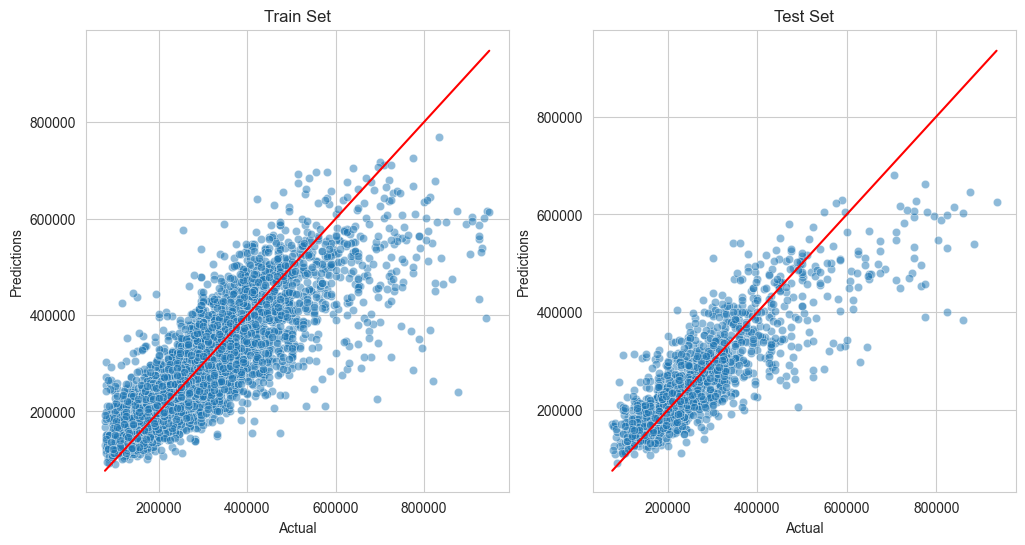

In [112]:
print("Regression Model Performance \nNote the MAE and MSE are in log(GBP) not GBP")
regression_performance(X_train, y_train, X_test, y_test, pipeline)

# calculate MAE and MSE should be in GBP not log(GBP) 
mae_train = mean_absolute_error(y_train_gbp, y_pred_train)
print(f"The train set Mean Absolute Error in GBP: {mae_train:,.0f}")

mae_test = mean_absolute_error(y_test_gbp, y_pred_gbp)
print(f"The test  set Mean Absolute Error in GBP: {mae:,.0f}")

alpha_scatter=0.5
# change the actuals and predictions to GBP
y_train_gbp = expm1(y_train)
y_test_gbp = expm1(y_test)
y_pred_gbp = expm1(pipeline.predict(X_test))
y_pred_train = expm1(pipeline.predict(X_train))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.scatterplot(x=y_train_gbp, y=y_pred_train, alpha=alpha_scatter, ax=axes[0])
sns.lineplot(x=y_train_gbp, y=y_train_gbp, color="red", ax=axes[0])
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predictions")
axes[0].set_title("Train Set")

sns.scatterplot(x=y_test_gbp, y=y_pred_gbp, alpha=alpha_scatter, ax=axes[1])
sns.lineplot(x=y_test_gbp, y=y_test_gbp, color="red", ax=axes[1])
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predictions")
axes[1].set_title("Test Set")

plt.show()


The performance on the train and test set is similar, indicating that the model is not overfitting.
At the same time, the test set performance (which is the best data to simulate real data since the model has never seen it) has an R2 performance of 0.74. 
This is a good R2 value for a baseline model.
We also note in the plots of Prediction x Actual, the predictions tend to follow the actual value. 
It is evident, however, that actual higher priced sold value properties are being undervalued. This needs further investigation.

In [113]:
# save the test set for future evaluation
test = X_test.copy()
test['log_price'] = y_test
test.to_csv('../data/clean/test_set.csv', index=False)